In [1]:
import xupy as xp
import matplotlib.pyplot as plt

from ekarus.e2e.devices.alpao_deformable_mirror import ALPAODM
from ekarus.e2e.utils.image_utils import get_circular_mask, reshape_on_mask
import ekarus.e2e.utils.deformable_mirror_utilities as dmutils


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
Npix = 128
anular_mask = xp.logical_or(get_circular_mask((Npix,Npix),mask_radius=Npix//2),~get_circular_mask((Npix,Npix),mask_radius=Npix//6))
alpao_mask = get_circular_mask((Npix,Npix),mask_radius=Npix//2)
DM468 = ALPAODM(468,alpao_mask)
DM241 = ALPAODM(241,alpao_mask)
DM820 = ALPAODM(820,alpao_mask)

Unobscured actuators: 732/820
[263 264 265 266 267 268 294 295 296 297 298 299 300 301 325 326 327 328
 329 330 331 332 333 334 357 358 359 360 361 362 363 364 365 366 389 390
 391 392 393 394 395 396 397 398 421 422 423 424 425 426 427 428 429 430
 453 454 455 456 457 458 459 460 461 462 485 486 487 488 489 490 491 492
 493 494 518 519 520 521 522 523 524 525 551 552 553 554 555 556]


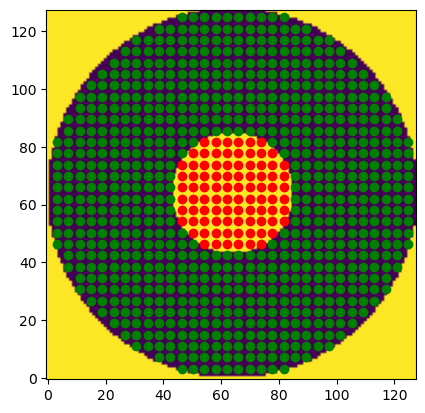

In [3]:
sDM820 = ALPAODM(820,pupil_mask=anular_mask)

is_slave = xp.ones(sDM820.Nacts, dtype=bool)
is_slave[sDM820.master_ids] = 0
slave_ids = xp.arange(sDM820.Nacts)
slave_ids = slave_ids[is_slave]

cmd = xp.zeros(sDM820.Nacts)
cmd[slave_ids] = 1e-6

pix_coords = dmutils.get_pixel_coords(anular_mask, sDM820.act_coords, sDM820.pixel_scale)

plt.figure()
plt.imshow(xp.asnumpy(anular_mask),origin='lower')
plt.scatter(xp.asnumpy(pix_coords[0,slave_ids]),xp.asnumpy(pix_coords[1,slave_ids]),c='red')
plt.scatter(xp.asnumpy(pix_coords[0,sDM820.master_ids]),xp.asnumpy(pix_coords[1,sDM820.master_ids]),c='green')

print(slave_ids)

np.float32(0.80407786)

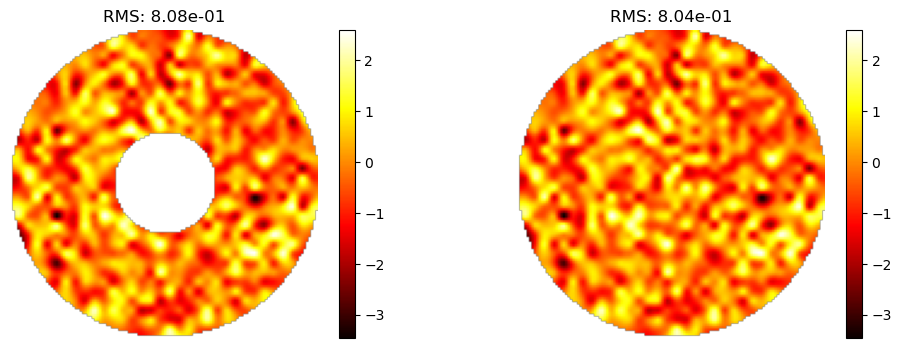

In [4]:
act_scramble = xp.random.randn(sDM820.Nacts)
surf_scramble = DM820.IFF @ act_scramble

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sDM820.plot_surface(surf_scramble, plt_mask = anular_mask)
plt.subplot(1,2,2)
DM820.plot_surface(surf_scramble)

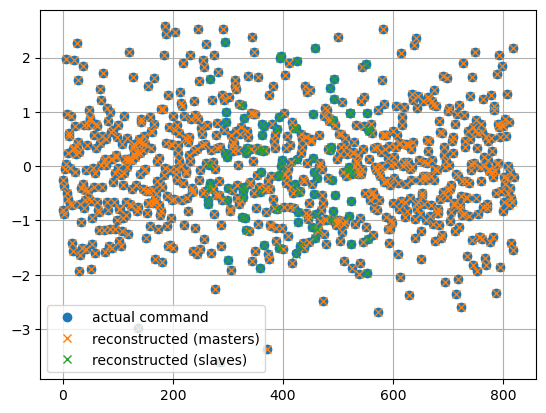

In [5]:
# Redefine reconstructor
maR = xp.linalg.pinv(sDM820.IFF[sDM820.visible_pix_ids,:])

ma_rec_cmd = maR @ surf_scramble[sDM820.visible_pix_ids]

plt.figure()
plt.plot(xp.asnumpy(act_scramble),'o',label='actual command')
plt.plot(xp.asnumpy(sDM820.master_ids), xp.asnumpy(ma_rec_cmd[sDM820.master_ids]),'x',label='reconstructed (masters)')
plt.plot(xp.asnumpy(slave_ids), xp.asnumpy(ma_rec_cmd[slave_ids]),'x',label='reconstructed (slaves)')
plt.grid()
plt.legend()

In [6]:
from ekarus.e2e.single_stage_ao_class import SingleStageAO

tn = 'slaving_single_stage'
ssao = SingleStageAO(tn)
ssao.pyr.set_modulation_angle(ssao.sc.modulationAngleInLambdaOverD)
KL, m2c = ssao.define_KL_modes(ssao.dm, zern_modes=5)
Rec, _ = ssao.compute_reconstructor(ssao.sc, KL, ssao.pyr.lambdaInM, amps=0.2)

Initializing devices ...
Unobscured actuators: 732/820
Modulating 3 [lambda/D] with 20 modulation steps


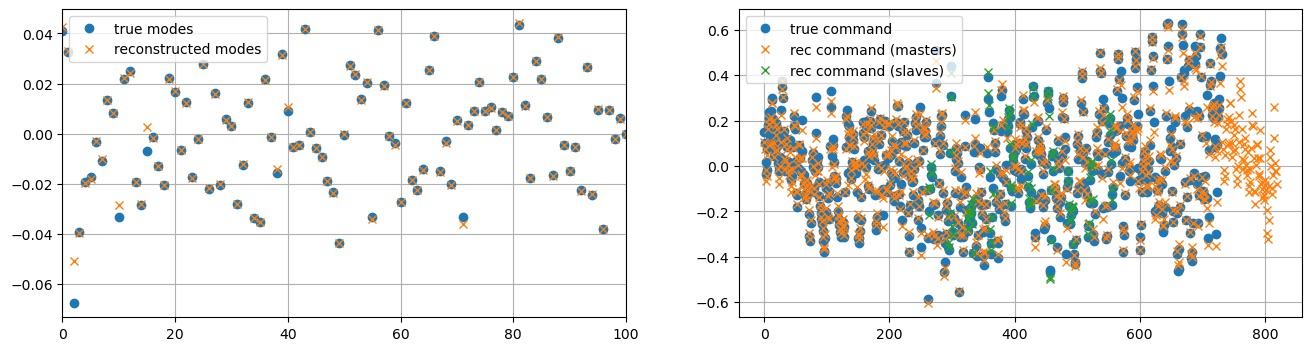

In [9]:
lambdaInM = ssao.pyr.lambdaInM
lambdaOverD = lambdaInM/ssao.pupilSizeInM
m2rad = (2*xp.pi)/lambdaInM

mmax = 100

modes = xp.random.randn(KL.shape[0])*0.025
modes[mmax:] = 0
KL_surf = xp.zeros(KL.shape[1])
for k,mode_id in enumerate(modes):
    KL_surf += KL[k,:]*modes[k]

phase = reshape_on_mask(KL_surf, ssao.cmask)
input_field = (1-ssao.cmask) * xp.exp(1j*phase)
slopes = ssao.sc.compute_slopes(input_field, lambdaOverD, None)
rec_modes = Rec @ slopes

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(xp.asnumpy(modes), 'o', label='true modes')
plt.plot(xp.asnumpy(rec_modes), 'x', label='reconstructed modes')
plt.xlim([0,mmax])
plt.legend()
plt.grid()

cmd = m2c @ modes
rec_cmd = m2c @ rec_modes

plt.subplot(1,2,2)
plt.plot(xp.asnumpy(cmd), 'o', label='true command')
plt.plot(xp.asnumpy(sDM820.master_ids),xp.asnumpy(rec_cmd[sDM820.master_ids]), 'x', label='rec command (masters)')
plt.plot(xp.asnumpy(slave_ids),xp.asnumpy(rec_cmd[slave_ids]), 'x', label='rec command (slaves)')
plt.legend()
plt.grid()

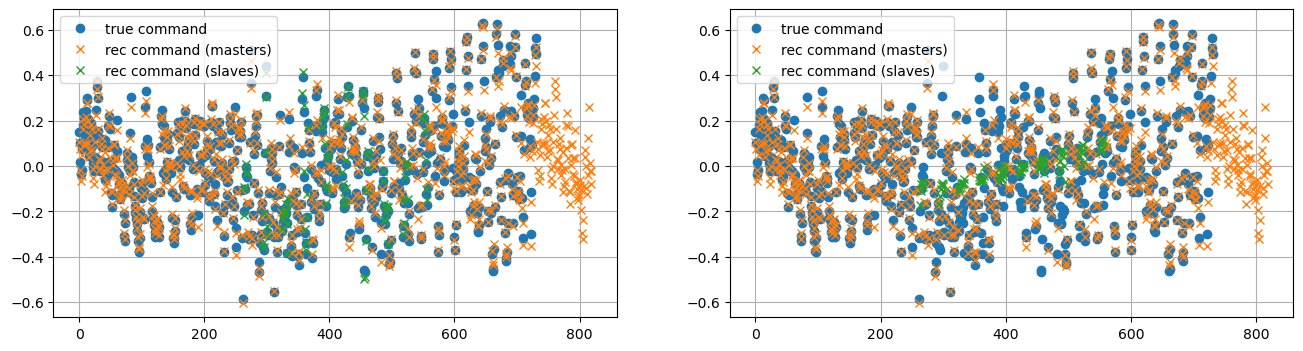

In [10]:
slaved_cmd = sDM820.slaving @ rec_cmd[sDM820.master_ids]

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(xp.asnumpy(cmd), 'o', label='true command')
plt.plot(xp.asnumpy(sDM820.master_ids),xp.asnumpy(rec_cmd[sDM820.master_ids]), 'x', label='rec command (masters)')
plt.plot(xp.asnumpy(slave_ids),xp.asnumpy(rec_cmd[slave_ids]), 'x', label='rec command (slaves)')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(xp.asnumpy(cmd), 'o', label='true command')
plt.plot(xp.asnumpy(sDM820.master_ids),xp.asnumpy(slaved_cmd[sDM820.master_ids]), 'x', label='rec command (masters)')
plt.plot(xp.asnumpy(slave_ids),xp.asnumpy(slaved_cmd[slave_ids]), 'x', label='rec command (slaves)')
plt.legend()
plt.grid()

In [12]:
# Check convergence
surface = KL_surf.copy()*1e-6
DM820.plot_surface(surface)
N=5
plt.figure(figsize=(18,4))
for i in range(N):
    phase = reshape_on_mask(surface, ssao.cmask)
    input_field = (1-ssao.cmask) * xp.exp(1j*phase*(2*xp.pi)/lambdaInM)
    slopes = ssao.sc.compute_slopes(input_field, lambdaOverD, None)
    rec_modes = Rec @ slopes
    rec_cmd = m2c @ rec_modes
    slaved_cmd = sDM820.slaving @ rec_cmd[sDM820.master_ids]
    slaved_cmd *= lambdaInM/(2*xp.pi)
    rec_surf = sDM820.IFF @ slaved_cmd
    surface -= rec_surf
    plt.subplot(1,N,i+1)
    DM820.plot_surface(surface,plt_mask=anular_mask)

ValueError: operands could not be broadcast together with shape (11416,) and requested shape (12849,)